# 31 - A Better Cross Validation
## Revisiting All-NBA Predictions
Hey folks. I'm writing this post about 2 months since the last post. I wanted to revisit this project because I've gotten acquainted a bit more data science tools and methods, and I wanted to apply them back to the model I built. There are a few reasons why I felt the uncontrollable urge to come back...

![](http://i.imgur.com/u7g0KbN.gif)

### 1. Automation
The entire time I was writing the last 2 posts where I made predictions on all-NBA players, first using an ensemble model and second using tree-based models (namely gradient boosting trees with xgboost), I was constantly bothered by the fact that I was listing out all the players and their probabilities and then hand-picking the ones who would the first, second, and thirm teams. It wasn't very efficient, and I was slightly ashamed of myself at the time, but I was just too excited that I got any model working that I didn't really take the time to automate that process. To go down the list and pick the first 6 guards, 6 forwards, and 3 centers is an extremely simple script to write and I aim to do that now.

### 2. Cross Validation
Cross validation is one of the most important parts in building a model as it ensures you prevent overfitting and decreases your out-of-sample error. The biggest reason I didn't implement cross validation before was that I didn't know how to use the cross validation libraries in R or python. python's sklearn has the _**model selection**_ and _**grid search**_ modules with a ton of tools to perform cross validation (something I was not finding very easily in R where models seem to have their own cross validation functions). Since I had modeled in R and scripted in python in the previous posts, I ran into some headaches switching back and forth between the two... Cross validation would've been _**much easier**_ if I had worked within a single language. Since I wrote my last post, I've become much more familiar with sklearn. I've also played quite a bit with the python implementation of xgboost, so I want to try to cross validate my previous result to get a more accurate score.

## Cross Validation Strategy
Although I mentioned that I had become a bit more familiar the sklearn _**grid search**_ module, I'm literally just realizing now that I don't think I can actually use it with the way that I want to perform cross validation. Yup, I'm talking about the time between me finishing the last paragraph and starting this one.

![](https://i.giphy.com/media/eI6NdZYSmzv20/giphy.webp)

Okay, in my own defense, I'm stupid because I don't have that much experience with model selection methods yet and I'm actually quickly finding that different data actually command different validation methods.

With the NBA data, cross-validation should theoretically tell me how accurate my model is, right? Well, what is the objective I'm actually trying to solve? It can be approached in two ways:
1. If I'm just using the model_selection tools to perform straight cross validation (let's say 5-fold CV), I would have my data split 80% train and 20% test for five iterations. My measurement of correctness would not take into account that there are only 6 G's, 6 F's, and 3 C's that make the team.
2. If I take a step back, the real accuracy of my model should be averaged over all the years of data we have, because what we really care about is _**how many of the 15 players we got each year**_. To achieve measurement using this criteria, we must train the model on all the other ~29 years (I think we have around 30 years of data) and measure accuracy with a "leave-one-out" cross validation approach, where the one out is not necessarily one sample, but one year's worth of data.

There are two cases where cross-validation is used:
1. To get a sense of the end-model accuracy
2. Tune parameters

Once I have my model, I can absolutely use the "leave-one-year-out" cross validation to gauge model score. If I tried to use the same appraoch for parameter tuning, I'd have 30x however many combinations of parameters I have. Even if I wanted to tune, let's say, 10 sets of parameters, I'd be training 300 model... this might be a bit too much.

I think to tune parameters, I'm going to just use _**GridSearchCV**_ from sklearn, and to measure overall model accuracy, I'll use the "leave-one-year-out" CV.

Leggo.

## Data Load & Initial Setup

In [123]:
# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn makes our plots prettier
import seaborn
seaborn.set(style = 'ticks')

import numpy as np
import pandas as pd
import copy

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar20170606.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [3]:
# Select braoder set of features manually
selectedCols = [
    'perGameStats_Age',
    'perGameStats_G',
    'perGameStats_GS',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FGPerc',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_3PPerc',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'accolades_all_nba'
]

playerAggDfAllNbaAllStarInitFeatures = playerAggDfAllNbaAllStar[selectedCols]

In [5]:
# Drop GS & 3P%
playerAggDfAllNbaAllStarInitFeatures = playerAggDfAllNbaAllStarInitFeatures.drop(['perGameStats_GS', 'per100Stats_3PPerc'], 1)

In [6]:
# Drop any rows with remaining NA's (FT% has 3 rows)
print playerAggDfAllNbaAllStarInitFeatures.shape
playerAggDfAllNbaAllStarInitFeatures.dropna(inplace = True)
print playerAggDfAllNbaAllStarInitFeatures.shape

(13223, 46)
(13220, 46)


## Building xgboost Model

In [22]:
# Load xgboost & sklearn modules
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [25]:
# Setting up x and y for training
x_train = playerAggDfAllNbaAllStarInitFeatures.ix[:, playerAggDfAllNbaAllStarInitFeatures.columns != 'accolades_all_nba']
y_train = playerAggDfAllNbaAllStarInitFeatures['accolades_all_nba']

In [29]:
# Hold out 10% for xgboost early stopping testing
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1, stratify = y_train)

In [31]:
# Encode y_train to 0 and 1
# Encode our labels to integers (e.g. "Dance" becomes a number like 1 or 2)
lb = LabelEncoder()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)
print 'Y (train) set has the following labels {} and has {} elements'.format(np.unique(y_train_encoded), len(y_train_encoded))
print 'Y (test) set has the following labels {} and has {} elements'.format(np.unique(y_test_encoded), len(y_test_encoded))

# Fit our train and test data to a xgb sparse matrix
xgb_train = xgb.DMatrix(x_train, label = y_train_encoded)
xgb_test = xgb.DMatrix(x_test, label = y_test_encoded)

Y (train) set has the following labels [0 1] and has 11898 elements
Y (test) set has the following labels [0 1] and has 1322 elements


In [32]:
# Instantiate model
xgb_model = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_grid_search = {
    'max_depth': [1, 5, 10],
    'learning_rate': [0.05, 0.1, 0.5, 1],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [10000]
}

fit_params = {
    'early_stopping_rounds': 100,
    'eval_metric': 'auc',
    'eval_set': [[x_test, y_test_encoded]],
    'verbose': 500
}

# Set up grid search
clf = GridSearchCV(
    xgb_model, 
    param_grid_search, 
    fit_params = fit_params,
    n_jobs = -1, 
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2, 
    refit = True
)

In [33]:
# Fit model
clf.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[0]	validation_0-auc:0.849076
Will train until validation_0-auc hasn't improved in 100 rounds.
[0]	validation_0-auc:0.84947
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[294]	validation_0-auc:0.994155

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -   5.0s
Stopping. Best iteration:
[291]	validation_0-auc:0.994382

[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -   5.2s
[0]	validation_0-auc:0.853407
Will train until validation_0-auc hasn't improved in 100 rounds.
[CV] n_estimators=10000, objective=binary:lo

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=5, silent=1 -  22.8s
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=5, silent=1 
[0]	validation_0-auc:0.980421
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[99]	validation_0-auc:0.993534

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=5, silent=1 -  10.0s
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=10, silent=1 
[0]	validation_0-auc:0.985425
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[55]	validation_0-auc:0.994473

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=5, silent=1 -   6.9s
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.1, max_depth=10, silent=1 
[0]	validation_0-auc:0.971177
Will train until validation_0-auc hasn't improved in 100 rounds.
Stoppi

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min


[0]	validation_0-auc:0.972176
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[70]	validation_0-auc:0.993337

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 -  10.5s
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 
[0]	validation_0-auc:0.980421
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[11]	validation_0-auc:0.995048

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 -   6.2s
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 
[0]	validation_0-auc:0.985425
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[9]	validation_0-auc:0.993171

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 -   6.5s
[CV] n_estimators=10000, objective=binary:lo

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.1min finished


[0]	validation_0-auc:0.969912
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[79]	validation_0-auc:0.993777



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_set': [[       perGameStats_Age  perGameStats_G  perGameStats_MP  per100Stats_FG  \
10516                24              79             26.5             5.1
6638                 29              82             28.5             6.6
12100                25              45       ...ns], array([1, 1, ..., 0, 1])]], 'early_stopping_rounds': 100, 'eval_metric': 'auc', 'verbose': 500},
       iid=True, n_jobs=-1,
       param_grid={'objective': ['binary:logistic'], 'n_estimators': [10000], 'learning_rate': [0.05, 0.1, 0.5, 1], 'max

In [36]:
# Check scores
clf.grid_scores_

[mean: 0.99036, std: 0.00328, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.05, 'max_depth': 1, 'silent': 1},
 mean: 0.99069, std: 0.00291, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.05, 'max_depth': 5, 'silent': 1},
 mean: 0.99122, std: 0.00243, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.05, 'max_depth': 10, 'silent': 1},
 mean: 0.99070, std: 0.00308, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.1, 'max_depth': 1, 'silent': 1},
 mean: 0.99091, std: 0.00277, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.1, 'max_depth': 5, 'silent': 1},
 mean: 0.99134, std: 0.00231, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.1, 'max_depth': 10, 'silent': 1},
 mean: 0.99071, std: 0.00278, params: {'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.5, 'ma

So it looks like it really doesn't matter. I mean, the fact that we're at 99% AUC is already good enough, ya know? We see that a learning rate of 1 consistently yielded (barely) lower scores, so let's go with something like a learning rate of 0.1 (to speed things up) and a max depth of 5. Let's do some tuning on _**subsample**_ and _**colsubsample bytree**_ which randomly samples rows and columns respectively each iteration. I didn't actually tune any parameters last time, so let's see if this model does _**even better**_.

In [39]:
# Instantiate model
xgb_model = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_grid_search = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [10000]
}

fit_params = {
    'early_stopping_rounds': 100,
    'eval_metric': 'auc',
    'eval_set': [[x_test, y_test_encoded]],
    'verbose': 500
}

# Set up grid search
clf = GridSearchCV(
    xgb_model, 
    param_grid_search, 
    fit_params = fit_params,
    n_jobs = -1, 
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2, 
    refit = True
)

In [40]:
# Fit model
clf.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.987757
Will train until validation_0-auc hasn't improved in 100 rounds.
[0]	validation_0-auc:0.972986
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[131]	validation_0-auc:0.994852

Stopping. Best iteration:
[128]	validation_0-auc:0.99414

[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 -  10.6s
[CV]  colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 -  10.8s
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, 

[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.98937
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[32]	validation_0-auc:0.994806

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 -   8.3s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.961849
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[47]	validation_0-auc:0.993701

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   8.2s
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min


[0]	validation_0-auc:0.973334
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[102]	validation_0-auc:0.993262

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -  11.2s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.972206
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[66]	validation_0-auc:0.994307

[CV]  colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 -   9.7s
[CV] colsample_bytree=1, silent=1, learning_rate=0.1, n_estimators=10000, subsample=1, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.985895
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[74]	validation_0-auc:0.994806

[CV]  co

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.9min finished


[0]	validation_0-auc:0.953505
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[59]	validation_0-auc:0.994246



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_set': [[       perGameStats_Age  perGameStats_G  perGameStats_MP  per100Stats_FG  \
10516                24              79             26.5             5.1
6638                 29              82             28.5             6.6
12100                25              45       ...ns], array([1, 1, ..., 0, 1])]], 'early_stopping_rounds': 100, 'eval_metric': 'auc', 'verbose': 500},
       iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': [0.8, 0.9, 1], 'silent': [1], 'learning_rate': [0.1], 'n_estimators': [10000], 's

In [44]:
# Check scores
clf.grid_scores_

[mean: 0.99136, std: 0.00253, params: {'colsample_bytree': 0.8, 'silent': 1, 'learning_rate': 0.1, 'n_estimators': 10000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 5},
 mean: 0.99148, std: 0.00251, params: {'colsample_bytree': 0.8, 'silent': 1, 'learning_rate': 0.1, 'n_estimators': 10000, 'subsample': 0.9, 'objective': 'binary:logistic', 'max_depth': 5},
 mean: 0.99127, std: 0.00273, params: {'colsample_bytree': 0.8, 'silent': 1, 'learning_rate': 0.1, 'n_estimators': 10000, 'subsample': 1, 'objective': 'binary:logistic', 'max_depth': 5},
 mean: 0.99129, std: 0.00234, params: {'colsample_bytree': 0.9, 'silent': 1, 'learning_rate': 0.1, 'n_estimators': 10000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 5},
 mean: 0.99139, std: 0.00243, params: {'colsample_bytree': 0.9, 'silent': 1, 'learning_rate': 0.1, 'n_estimators': 10000, 'subsample': 0.9, 'objective': 'binary:logistic', 'max_depth': 5},
 mean: 0.99124, std: 0.00261, params: {'colsample_bytree'

In [43]:
# Best model
clf.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 10000,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8}

They are all really good models to be honest, but let's just take the one that GridSearchCV found as the best.

## "Leave One Year Out" Cross Validation
Okay, so I have a model that seems to be doing pretty well. The next thing I need to do is go through each year and figure out what my final "accuracy" score is for this model. That is, what is the average amount of players I picked correctly out of the 15 chosen all-NBA players?

To re-iterate my point in the intro paragraphs, I can get a ranking of probabilities of how likely the model thinks the player is all-NBA, but it is not enough to _**simply pick the top 15 players that come up**_. What if the top 15 players with the best all-NBA probabilities are all guards? It's impossible to have an all-NBA team with only guards as per the definition of an all-NBA _**TEAM**_. I need to write a bit of logic to take the
- top 6 guards (2 per team)
- top 6 forwards (2 per team)
- top 3 centers (1 per team)

Also, there is an additional nuance in that the league, prior to the _**1988 - 1989**_ season, there were only _**two**_ all-NBA teams. Since then, there have been _**three**_ all-NBA teams. So, realistically, I will be counting the following:
- Before 1988 - 1989 season:
    - top 4 guards (2 per team)
    - top 4 forwards (2 per team)
    - top 2 centers (1 per team)
- 1988 - 1989 season to present:
    - top 6 guards (2 per team)
    - top 6 forwards (2 per team)
    - top 3 centers (1 per team)

Let's try it out.

In [48]:
# Review our dataframe of original full test set
playerAggDfAllNbaAllStar.head()

,season_start_year,perGameStats_Player,perGameStats_Pos,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,...,advancedStats_VORP,player_formatted,Tm,Player_x,Player_y,all_star,accolades,accolades_any_team,VORP_WS_sum,accolades_all_nba
0,1979,Kareem Abdul-Jabbar*,C,32,LAL,82,NaN,38.3,12.3,20.3,...,6.8,kareemabduljabbar,1st,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,All Star,All-NBA First Team,On Team,21.6,All-NBA
1,1979,Tom Abernethy,PF,25,GSW,67,NaN,18.2,6.0,12.4,...,0.1,tomabernethy,NaN,NaN,NaN,NaN,No Team,No Team,2.1,Not All-NBA
2,1979,Alvan Adams,C,25,PHO,75,NaN,28.9,9.8,18.5,...,3.5,alvanadams,NaN,NaN,NaN,NaN,No Team,No Team,10.5,Not All-NBA
3,1979,Tiny Archibald*,PG,31,BOS,80,80.0,35.8,6.3,13.0,...,1.5,tinyarchibald,NaN,NaN,NaN,NaN,No Team,No Team,10.4,Not All-NBA
4,1979,Dennis Awtrey,C,31,CHI,26,NaN,21.5,2.3,5.0,...,0.1,dennisawtrey,NaN,NaN,NaN,NaN,No Team,No Team,0.7,Not All-NBA


In [49]:
# View cleaned test set for model training
playerAggDfAllNbaAllStarInitFeatures.head()

,perGameStats_Age,perGameStats_G,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_2P,per100Stats_2PA,...,advancedStats_USGPerc,advancedStats_OWS,advancedStats_DWS,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba
0,32,82,38.3,12.3,20.3,0.604,0.0,0.0,12.3,20.3,...,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,All-NBA
1,25,67,18.2,6.0,12.4,0.481,0.0,0.0,6.0,12.4,...,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,Not All-NBA
2,25,75,28.9,9.8,18.5,0.531,0.0,0.0,9.8,18.4,...,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,Not All-NBA
3,31,80,35.8,6.3,13.0,0.482,0.1,0.3,6.2,12.7,...,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,Not All-NBA
4,31,26,21.5,2.3,5.0,0.450,0.0,0.0,2.3,5.0,...,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,Not All-NBA


In [69]:
# Merge season, player name, and position back into the cleaned dataframe
playerAggDfAllNbaAllStarInitFeaturesFullSet = playerAggDfAllNbaAllStarInitFeatures.merge(
    playerAggDfAllNbaAllStar[['season_start_year', 'perGameStats_Player', 'perGameStats_Pos']],
    how = 'left',
    left_index = True,
    right_index = True
)

# Check results
playerAggDfAllNbaAllStarInitFeaturesFullSet.tail()

,perGameStats_Age,perGameStats_G,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_2P,per100Stats_2PA,...,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba,season_start_year,perGameStats_Player,perGameStats_Pos
13218,28,74,30.2,8.1,15.4,0.527,1.0,2.6,7.1,12.7,...,4.6,0.099,0.0,1.5,1.5,2.0,Not All-NBA,2016,Thaddeus Young,PF
13219,24,62,27.8,7.4,12.9,0.571,0.0,0.0,7.4,12.9,...,5.6,0.157,-0.2,2.3,2.1,1.8,Not All-NBA,2016,Cody Zeller,PF
13220,27,51,10.3,7.4,14.9,0.494,0.0,0.1,7.4,14.8,...,1.0,0.094,-3.2,0.8,-2.5,-0.1,Not All-NBA,2016,Tyler Zeller,C
13221,22,44,19.2,5.3,13.2,0.398,2.0,5.9,3.3,7.3,...,0.5,0.030,-3.6,-0.1,-3.7,-0.4,Not All-NBA,2016,Paul Zipser,SF
13222,19,38,16.0,10.1,19.0,0.529,0.0,0.2,10.1,18.8,...,1.1,0.086,-2.7,0.3,-2.5,-0.1,Not All-NBA,2016,Ivica Zubac,C


In [70]:
# Unique years
unique_years_list = playerAggDfAllNbaAllStarInitFeaturesFullSet['season_start_year'].unique().tolist()
print 'There are {} seasons from {} to {}'.format(len(unique_years_list), np.min(unique_years_list), np.max(unique_years_list))

There are 37 seasons from 1979 to 2016


Let's first calculate the probabilities of all-NBA team selection based on the model we built. I'll generate the probabilities using GridSearchCV's predict\_proba method.

In [180]:
# Calculate all-star probabilities for our entire data set
#    Build test data to model on (filter for year)
x_test_full = copy.deepcopy(playerAggDfAllNbaAllStarInitFeaturesFullSet)
x_test_selected_features = x_test_full[playerAggDfAllNbaAllStarInitFeatures.columns]
x_test_no_labels = x_test_selected_features.drop('accolades_all_nba', 1)
print 'Input test set contains shape {}'.format(x_test_no_labels.shape)

# Make prediction using our xgboost model (best iteration is stored in clf with a predict_proba() method)
y_test_pred = clf.predict_proba(x_test_no_labels)
y_test_pred_df = pd.DataFrame(y_test_pred, columns = ['all_NBA_proba', 'not_all_NBA_proba'])
print 'Predicted labels contains shape {}'.format(y_test_pred_df.shape)

# Merge predictions back into full data set so we can access positions and true labels
x_test_full['y_test_pred_proba'] = y_test_pred_df['all_NBA_proba'].tolist()

Input test set contains shape (13220, 45)
Predicted labels contains shape (13220, 2)


In [181]:
# Check results
x_test_full.head()

,perGameStats_Age,perGameStats_G,perGameStats_MP,per100Stats_FG,per100Stats_FGA,per100Stats_FGPerc,per100Stats_3P,per100Stats_3PA,per100Stats_2P,per100Stats_2PA,per100Stats_2PPerc,per100Stats_FT,per100Stats_FTA,per100Stats_FTPerc,per100Stats_ORB,per100Stats_DRB,per100Stats_TRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV,per100Stats_PF,per100Stats_PTS,per100Stats_ORtg,per100Stats_DRtg,advancedStats_PER,advancedStats_TSPerc,advancedStats_3PAr,advancedStats_FTr,advancedStats_ORBPerc,advancedStats_DRBPerc,advancedStats_TRBPerc,advancedStats_ASTPerc,advancedStats_STLPerc,advancedStats_BLKPerc,advancedStats_TOVPerc,advancedStats_USGPerc,advancedStats_OWS,advancedStats_DWS,advancedStats_WS,advancedStats_WS48,advancedStats_OBPM,advancedStats_DBPM,advancedStats_BPM,advancedStats_VORP,accolades_all_nba,season_start_year,perGameStats_Player,perGameStats_Pos,y_test_pred_proba
0,32,82,38.3,12.3,20.3,0.604,0.0,0.0,12.3,20.3,0.604,5.3,7.0,0.765,2.8,10.2,13.0,5.4,1.2,4.1,4.4,3.2,29.8,118.0,100.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,All-NBA,1979,Kareem Abdul-Jabbar*,C,0.996108
1,25,67,18.2,6.0,12.4,0.481,0.0,0.0,6.0,12.4,0.483,2.2,3.2,0.683,2.4,5.0,7.5,3.4,1.4,0.5,1.5,4.6,14.1,109.0,108.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,Not All-NBA,1979,Tom Abernethy,PF,0.000007
2,25,75,28.9,9.8,18.5,0.531,0.0,0.0,9.8,18.4,0.533,4.0,5.0,0.797,3.3,9.5,12.9,6.8,2.3,1.2,4.6,5.0,23.6,107.0,99.0,19.2,0.571,0.002,0.270,8.2,22.4,15.4,21.6,2.3,1.4,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,Not All-NBA,1979,Alvan Adams,C,0.000461
3,31,80,35.8,6.3,13.0,0.482,0.1,0.3,6.2,12.7,0.488,5.9,7.1,0.830,1.0,2.3,3.2,11.0,1.7,0.2,4.0,3.6,18.5,115.0,105.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,Not All-NBA,1979,Tiny Archibald*,PG,0.030056
4,31,26,21.5,2.3,5.0,0.450,0.0,0.0,2.3,5.0,0.450,2.7,4.2,0.640,2.4,7.2,9.7,3.4,1.0,1.3,2.3,5.6,7.2,102.0,107.0,7.4,0.524,0.000,0.833,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,Not All-NBA,1979,Dennis Awtrey,C,0.000018


In [182]:
# This function takes in a dataframe of the players' names, positions, and predicted probabiity of all-NBA and returns
#   the predicted team selected by the model
def select_team(x_test_full, year):
    # Define dict of number of players to select
    player_counters = {}
    
    # Define the number of guards to select depending on the year
    if year < 1988:
        player_counters['G'] = 4
    else:
        player_counters['G'] = 6
        
    # Define the number of forwards and centers to select (both dependent on guards)
    player_counters['F'] = copy.deepcopy(player_counters['G'])
    player_counters['C'] = copy.deepcopy(player_counters['G']) / 2
    
    # Define empty dataframe to store players we found
    all_nba_selected_df = None
    
    # Sort dataframe by y_test_pred_proba
    x_test_full.sort_values('y_test_pred_proba', ascending = False, inplace = True)
    
    print 'Year {}: Finding the top {} guards, {} forwards, and {} centers'.format(year, player_counters['G'], player_counters['F'], player_counters['C'])
    
    # Loop through each position and select top guards, forwards, and centers
    for position in player_counters:
        x_test_full_position = x_test_full[x_test_full['perGameStats_Pos'].str.contains(position)][['season_start_year', 'perGameStats_Player', 'perGameStats_Pos', 'accolades_all_nba', 'y_test_pred_proba']].head(player_counters[position])
        
        # Append the results from each position to the final results dataframe
        if all_nba_selected_df is None:
            all_nba_selected_df = copy.deepcopy(x_test_full_position)
        else:
            all_nba_selected_df = pd.concat([all_nba_selected_df, x_test_full_position])
    
    # Return dataframe of all selected players in the year
    return all_nba_selected_df

# Initiate empty dataframe to store all the predicted results
all_nba_all_year_predicted_df = None

# Loop and predict for every year, calculating the number of players predicted correctly
i = 1
for year in playerAggDfAllNbaAllStarInitFeaturesFullSet['season_start_year'].unique().tolist():
    print 'Starting year {}'.format(year)
    
    # Build test data to model on (filter for year)
    all_nba_selected_df = select_team(x_test_full[x_test_full['season_start_year'] == year], year)
    
    # Append the results from each year to the final results dataframe
    if all_nba_all_year_predicted_df is None:
        all_nba_all_year_predicted_df = copy.deepcopy(all_nba_selected_df)
    else:
        all_nba_all_year_predicted_df = pd.concat([all_nba_all_year_predicted_df, all_nba_selected_df])
        
print all_nba_all_year_predicted_df

Starting year 1979


/Users/chiwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Year 1979: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1980
Year 1980: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1981
Year 1981: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1982
Year 1982: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1983
Year 1983: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1984
Year 1984: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1985
Year 1985: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1986
Year 1986: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1987
Year 1987: Finding the top 4 guards, 4 forwards, and 2 centers
Starting year 1988
Year 1988: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1989
Year 1989: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1990
Year 1990: Finding the top 6 guards, 6 forwards, and 3 centers
Starting year 1991
Year 1991: Findi

In [184]:
# Merge selections back into main data frame
all_nba_all_year_predicted_df['y_test_pred'] = 'All-NBA'

x_test_full = x_test_full.merge(
    all_nba_all_year_predicted_df[['y_test_pred']],
    how = 'left',
    left_index = True,
    right_index = True
)

In [186]:
# The left join merge above leaves Non All-NBA selections as NaN, let's replace them with "Not All-NBA" to match y_test values
x_test_full['y_test_pred'].fillna('Not All-NBA', inplace = True)

In [187]:
# Check results
x_test_full[['accolades_all_nba', 'y_test_pred']].head()

,accolades_all_nba,y_test_pred
0,All-NBA,All-NBA
1,Not All-NBA,Not All-NBA
2,Not All-NBA,Not All-NBA
3,Not All-NBA,Not All-NBA
4,Not All-NBA,Not All-NBA


Let's check the importance plot of the model using xgboost's plot_importance method:

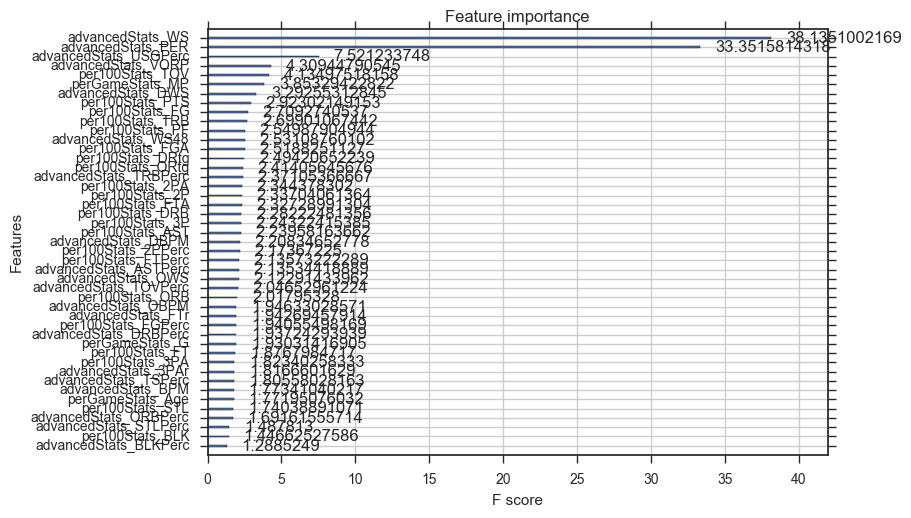

In [213]:
# Plot feature importance with xgboost
from xgboost import plot_importance
plot_importance(clf.best_estimator_, importance_type = 'gain')

Like we saw in earlier posts, the importance plot (using "gain" as the method of calculating importance, which measures the improvement of the models after making splits on that specific feature) shows that WS and PER are by far the most important splits, with USG\% trailing them VORP, along with all the other features following but seemingly insignificant.

Okay, so we now we've automated the choosing of our all-NBA players according to the criteria earlier (4 G / 4 F / 2 C before 1988, 6 G / 6 F / 4 C including and after 1988). Let's see how many we classified are actually all-NBA and how many are actually not all-NBA.

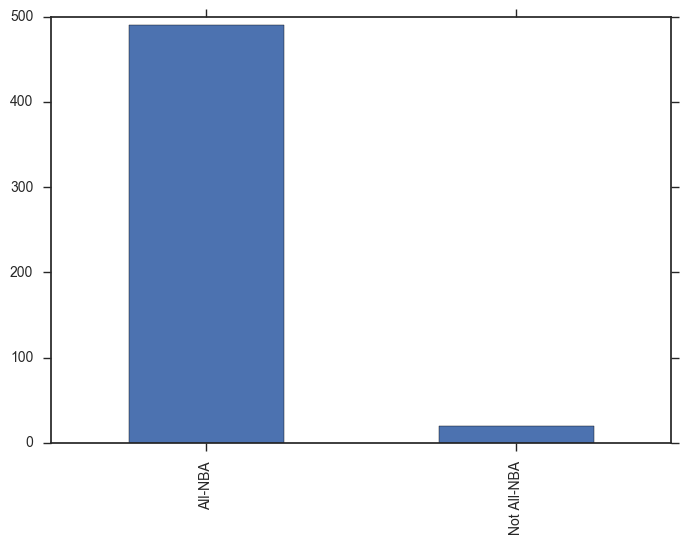

In [183]:
all_nba_all_year_predicted_df['accolades_all_nba'].value_counts().plot(kind = 'bar')

In [162]:
# Show tallies of predictions
all_nba_all_year_predicted_df['accolades_all_nba'].value_counts()

All-NBA        490
Not All-NBA     20
Name: accolades_all_nba, dtype: int64

490 predicted correctly out of 510... that's good for <span style="color:red">_**96% accuracy!!!!!!**_</span> Let's take a look at some of those that we predicted incorrectly.

In [164]:
# View all players predicted by our model as all-NBA but actually did not make a team
all_nba_all_year_predicted_df[all_nba_all_year_predicted_df['accolades_all_nba'] == 'Not All-NBA']

,season_start_year,perGameStats_Player,perGameStats_Pos,accolades_all_nba,y_test_pred_proba
58,1979,Walter Davis,SF,Not All-NBA,0.078551
1651,1984,Dominique Wilkins*,SF,Not All-NBA,0.935905
3140,1989,Dominique Wilkins*,SF,Not All-NBA,0.204918
4001,1992,Shaquille O'Neal*,C,Not All-NBA,0.970169
5184,1996,Mookie Blaylock,PG,Not All-NBA,0.542457
5668,1997,Kevin Garnett,PF,Not All-NBA,0.066664
6854,2001,Karl Malone*,PF,Not All-NBA,0.147331
6697,2001,Elton Brand,PF,Not All-NBA,0.122960
7234,2002,Brad Miller,C,Not All-NBA,0.001644
7585,2003,Andrei Kirilenko,PF,Not All-NBA,0.115170


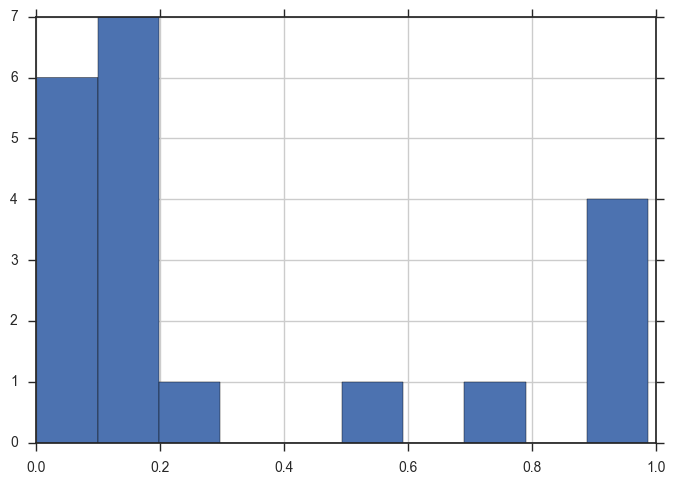

In [165]:
# Plot distribution of model-predicted all-NBA players who are actually not all-NBA
all_nba_all_year_predicted_df[all_nba_all_year_predicted_df['accolades_all_nba'] == 'Not All-NBA']['y_test_pred_proba'].hist()

It looks like 4 of the players in here ('84 'Nique, '92 Shaq, '05 Pau, '06 Tony Parker) had >90% probability of making the team. I think the model did the right thing in choosing these players, but clearly they were beat out by players with intangibles or situational advantages (on a really winning team... etc). I can investigate this later perhaps.

We see ~20 some odd folks here over the years who our model thinks made the team despite having predicted probabilities of _**under 30%**_. This doesn't sound right, but I'm thinking maybe those positions in that year were very low on talent, and just to round out the all-NBA teams, they had to reach to the bottom of the barrel... Let's look at one year in depth:

In '97, KG made the team while our model thinks he had a 6.7% chance of making it. What did that all-NBA forwards look like?

In [214]:
# Define set of columns to look at so we can make our analysis more concise
cols_to_view = [
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Pos',
    'advancedStats_USGPerc',    
    'advancedStats_WS',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'advancedStats_PER',
    'accolades_all_nba',
    'y_test_pred',
    'y_test_pred_proba'
]

In [216]:
# Look at forwards in all-NBA team in '97
x_test_full[(x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 1997) & (x_test_full['perGameStats_Pos'].str.contains('F'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
5642,1997,Tim Duncan,PF,26.0,12.8,5.5,6.0,22.6,All-NBA,All-NBA,0.995530
5693,1997,Grant Hill,SF,27.3,10.2,4.8,5.6,21.2,All-NBA,All-NBA,0.961537
5739,1997,Karl Malone*,PF,31.8,16.4,7.0,6.9,27.9,All-NBA,All-NBA,0.993458
5799,1997,Scottie Pippen*,SF,24.4,6.6,5.8,3.2,20.4,All-NBA,All-NBA,0.843303
5816,1997,Glen Rice,SF,25.1,9.3,0.7,2.3,17.4,All-NBA,All-NBA,0.847397


Hmm, it looks like there are only 5 forwards in the all-NBA team...

In [217]:
# Look at all-NBA team in '97
x_test_full[(x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 1997) & (x_test_full['perGameStats_Pos'].str.contains('C'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
5564,1997,Vin Baker,C,24.7,10.4,2.0,3.0,20.4,All-NBA,Not All-NBA,0.812960
5774,1997,Dikembe Mutombo*,C,17.6,10.8,2.5,3.3,19.8,All-NBA,All-NBA,0.834409
5779,1997,Shaquille O'Neal*,C,32.9,10.2,4.6,3.6,28.8,All-NBA,All-NBA,0.990341
5824,1997,David Robinson*,C,29.7,13.8,7.8,6.1,27.8,All-NBA,All-NBA,0.997089


And there are 4 centers! According to the [wikipedia page for the '97 season](https://en.wikipedia.org/wiki/1997%E2%80%9398_NBA_season), Vin Baker took the other forward spot, _**while basketball-reference had him listed as a C**_. The Forward landscape that year must've been quite thin and / or Vin Baker was pretty good that year as well (decent VORP and great Win Shares). Regardless, my programmed logic for selecting all-NBA players by positions prevented me from selecting Vin Baker because all the other all-NBA guys had great stats (Robinson, Shaq, Mutombo).

Let's check another year here where Pau got left off the '05 team:

In [218]:
# Look at all-NBA team in '05
x_test_full[((x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 2005) & (x_test_full['perGameStats_Pos'].str.contains('F'))) | ((x_test_full['season_start_year'] == 2005) & (x_test_full['perGameStats_Player'] == 'Pau Gasol'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
8236,2005,Carmelo Anthony,SF,32.0,9.4,1.5,2.6,22.0,All-NBA,Not All-NBA,0.864007
8276,2005,Elton Brand,PF,27.7,14.8,6.3,6.5,26.5,All-NBA,All-NBA,0.965451
8328,2005,Tim Duncan,PF,27.7,10.8,4.6,4.6,23.1,All-NBA,All-NBA,0.985211
8355,2005,Pau Gasol,PF,26.4,12.0,5.1,5.6,22.7,Not All-NBA,All-NBA,0.987017
8406,2005,LeBron James,SF,33.6,16.3,9.3,9.5,28.1,All-NBA,All-NBA,0.998779
8444,2005,Shawn Marion,PF,22.3,14.6,5.3,5.9,23.6,All-NBA,All-NBA,0.971578
8484,2005,Dirk Nowitzki,PF,30.0,17.7,5.7,6.0,28.1,All-NBA,All-NBA,0.996984


It looks like Pau was very deserving of an all-NBA team... in fact his stats were pretty crazy across the board. The 12 WS speaks volumes as we saw how important WS was in the tree's decisions. Melo was the proud recipient of third team honors in Pau's place, and he's got much lower percentage confidence of making the all-NBA team as predicted by our model (86\% vs Pau's 99\%). Melo definitely has very good usage rate and PER, but nowhere near the WS or VORP as anyone else on this list.

It seems that Pau is the clear choice, but I'm basically forced to nitpick here at why I don't think he was chosen. I can't find too many articles online, but from the bit of reading I just did, it seems that Melo lead the nuggets to the division title that year and he did it seemingly alone (hence the super high usage rate). Perhaps [Melo had such a bad team](http://www.basketball-reference.com/teams/DEN/2006.html) that to even get to 9.4 WS is a feat. Realistically, however, [Pau didn't have it any better than Melo did](http://www.basketball-reference.com/teams/MEM/2006.html) and he squeezed out more wins than Melo did too. Simply put, basketball-wise, it seems that Pau was more deserving, which leads me to think think that there were simply too many PFs on the all NBA teams. I've been generalizing both PFs and SFs to Fs, but I can understand the logic of lack of diversity if Pau was picked (would've resulted in 5 PFs and 1 true SF in Lebron). Intersting stuff...

Let's take a look at maybe one more. Let's go 2014 Kawhi.

In [219]:
# Look at all-NBA team in '14
x_test_full[((x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 2014) & (x_test_full['perGameStats_Pos'].str.contains('F'))) | ((x_test_full['season_start_year'] == 2014) & (x_test_full['perGameStats_Player'] == 'Kawhi Leonard'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
11907,2014,LaMarcus Aldridge,PF,30.2,8.6,0.3,1.4,22.8,All-NBA,All-NBA,0.981677
12006,2014,Anthony Davis,PF,27.8,14.0,7.1,5.7,30.8,All-NBA,All-NBA,0.978957
12050,2014,Pau Gasol,PF,24.7,10.4,2.8,3.2,22.7,All-NBA,All-NBA,0.788031
12072,2014,Blake Griffin,PF,28.4,9.0,4.1,3.6,22.8,All-NBA,All-NBA,0.854320
12111,2014,LeBron James,SF,32.3,10.4,7.4,5.9,25.9,All-NBA,All-NBA,0.984318
12151,2014,Kawhi Leonard,SF,23.0,8.6,6.1,4.1,22.0,Not All-NBA,All-NBA,0.067068


Another case of the ambiguously labeled C?

In [220]:
# Look at all-NBA team in '14
x_test_full[(x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 2014) & (x_test_full['perGameStats_Pos'].str.contains('C'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
11995,2014,DeMarcus Cousins,C,34.1,6.0,4.7,3.4,25.2,All-NBA,All-NBA,0.928775
12024,2014,Tim Duncan,C,22.2,9.6,5.5,4.2,22.6,All-NBA,Not All-NBA,0.838353
12049,2014,Marc Gasol,C,24.6,10.2,4.8,4.6,21.7,All-NBA,All-NBA,0.897962
12129,2014,DeAndre Jordan,C,13.6,12.8,4.1,4.3,21.0,All-NBA,All-NBA,0.959943


This kinda makes sense. Tim was always shuffling between C and PF, so the fact that Tim should've made it over Kawhi (which is exactly what happened) is absolutely believable.

OK - LET'S TRY ONE MORE... This is actually getting kind of addicting...

<img src="https://i.giphy.com/media/lmtP98SnFwExO/source.gif" width="500" />

Let's go '06 Tony Parker. Another one that the model predicted to have a great probability of success but fell flat.

In [222]:
# Look at all-NBA team in '06
x_test_full[((x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['season_start_year'] == 2006) & (x_test_full['perGameStats_Pos'].str.contains('G'))) | ((x_test_full['season_start_year'] == 2006) & (x_test_full['perGameStats_Player'] == 'Tony Parker'))][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
8631,2006,Gilbert Arenas,PG,31.4,10.8,5.0,5.2,24.0,All-NBA,Not All-NBA,0.680562
8650,2006,Chauncey Billups,PG,21.5,11.4,4.4,4.1,21.3,All-NBA,All-NBA,0.850024
8672,2006,Kobe Bryant,SG,33.6,13.0,4.7,5.3,26.1,All-NBA,All-NBA,0.978527
8850,2006,Tracy McGrady,SG,35.0,8.6,6.2,5.2,23.2,All-NBA,All-NBA,0.955374
8876,2006,Steve Nash,PG,22.9,12.6,3.8,3.9,23.8,All-NBA,All-NBA,0.991104
8895,2006,Tony Parker,PG,27.4,9.6,2.7,3.0,21.4,Not All-NBA,All-NBA,0.958577
8965,2006,Dwyane Wade,SG,34.7,8.8,8.4,5.1,28.9,All-NBA,All-NBA,0.991057


Ok. My question has now changed. Gilbert Arenas is the one that made it over TP, but I _**totally**_ get it because Gilbert went into god mode with a pretty bad team. Gilbert Arenas was _**BADASS**_ that season and has every right to be on that team purely because of all the buzzer beaters and games he just took over that season. This doesn't take away from the fact that TP was performing great as well.

The model says that TP was at around 96\% of making it on the team, and Chauncey Billups was at around 85\%, so my question is now, why did Chauncey make it over TP? In the 2006 - 2007 season, Mr Big Shot lead his team to a 53 win record while TP lead his team to a 58 win record... hmm... Mr Big Shot has a higher WS though... responsible for ~2 more wins than TP was for his team. Does this speak to how efficient those Pistons were that Chauncey was able to generate so many Win Shares out of so little usage? At the end of the day, if we look at the two most importance features in WS and USG\%, it kinda is a tossup between those two...

Okay. I'm done diving into some of these scenarios. I do have one more question before I wrap it up here. Earlier, I looked at the distribution of probabilities of those who the model predicted to make a team but ultimately they didn't. I want to take a look at the distributions of probabilities for the other way around - Those who actually made a team, but the model predicted that they wouldn't.

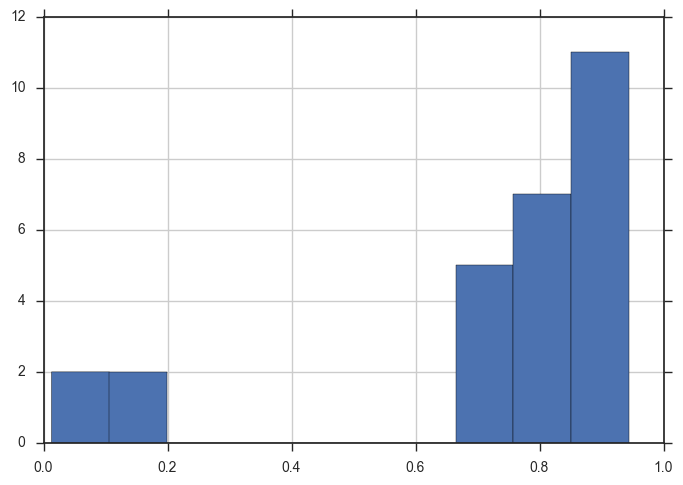

In [223]:
# Plot distribution of model-predicted non all-NBA players who are actually all-NBA
x_test_full[(x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['y_test_pred'] == 'Not All-NBA')]['y_test_pred_proba'].hist()

In [224]:
x_test_full[(x_test_full['accolades_all_nba'] == 'All-NBA') & (x_test_full['y_test_pred'] == 'Not All-NBA')][cols_to_view]

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_USGPerc,advancedStats_WS,advancedStats_BPM,advancedStats_VORP,advancedStats_PER,accolades_all_nba,y_test_pred,y_test_pred_proba
228,1979,Dan Roundfield,PF,22.8,9.1,4.6,4.3,19.7,All-NBA,Not All-NBA,0.058531
1601,1984,Ralph Sampson*,PF,25.9,6.2,0.8,2.1,17.4,All-NBA,Not All-NBA,0.806410
3031,1989,Chris Mullin*,SF,24.8,10.2,4.8,4.9,22.7,All-NBA,Not All-NBA,0.170011
3890,1992,Patrick Ewing*,C,29.7,10.6,2.2,3.2,20.8,All-NBA,Not All-NBA,0.904799
4176,1993,Derrick Coleman,PF,25.3,9.9,4.5,4.5,21.4,All-NBA,Not All-NBA,0.854670
4420,1993,Dominique Wilkins*,SF,31.9,2.6,0.0,0.5,21.8,All-NBA,Not All-NBA,0.908415
4639,1994,Reggie Miller*,SG,24.6,11.4,4.3,4.3,20.1,All-NBA,Not All-NBA,0.828209
4687,1994,Mitch Richmond*,SG,27.0,8.0,1.8,3.0,17.2,All-NBA,Not All-NBA,0.812528
5295,1996,Anfernee Hardaway,PG,25.7,8.1,4.7,3.8,21.4,All-NBA,Not All-NBA,0.170298
5564,1997,Vin Baker,C,24.7,10.4,2.0,3.0,20.4,All-NBA,Not All-NBA,0.812960


One pattern right off the bat here is that like 2 / 3 of these are _**CENTERS**_!!! We had difficulties with centers before, and the fact that half the amount of centers are taken compared to guards or forwards doesn't help either. It seems it's relatively difficult to classify centers, or rather, there is more room for subjectivity here. In modern eras, the center is generally not the centerpiece (heh...) of the team either. It's usuallly an agile G or F who can take over and the C nowadays provides extra rebounding or spacing. We see many deserving candidates for C, and this is no surprise as less spots simply means more chances of being snubbed by our model. The fact that the distribution shows such high probabilities (only 4 players under ~70\%) is a sign that there were many good players and something had to give.

One _**LAST**_ thing I'd like to look at... the model _**predicted all 2016 - 2017 all-NBA team members successfully**_! We didn't get this in our last model, so looks like cross validation (and the fact that I trained and tested on the same data, albeit a super small portion) has immediately noticeable benefits! I got about 13 / 15 in my last model, good for 86%. _**My cross-validated score on the entire dataset is frickin 96%**_.

<img src="https://i.giphy.com/media/3o7qDSOvfaCO9b3MlO/giphy.webp" width="400" />